In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

from scipy.stats import kstest
from scipy.interpolate import interp1d

In [2]:

def load_fiberstats_by_tracer(tracer='ELG'):
    min_nobs = 50

    cat = Table(fitsio.read('/global/cfs/cdirs/desicollab/users/rongpu/redshift_qa/jura_data/{}.fits'.format(tracer.lower())))


    cat['EFFTIME_BGS'] = 0.1400 * cat['TSNR2_BGS']
    cat['EFFTIME_LRG'] = 12.15 * cat['TSNR2_LRG']

    # Remove FIBERSTATUS!=0 fibers
    mask = cat['COADD_FIBERSTATUS']==0
    print('FIBERSTATUS   ', np.sum(~mask), np.sum(mask), np.sum(~mask)/len(mask))
    cat = cat[mask]

    # Remove "no data" fibers
    mask = cat['ZWARN'] & 2**9==0
    print('No data   ', np.sum(~mask), np.sum(mask), np.sum(~mask)/len(mask))
    cat = cat[mask]

    # Require a minimum depth for the cat coadd
    if tracer=='BGS_ANY':
        min_depth = 160
        mask = cat['EFFTIME_BGS']>min_depth
    else:
        min_depth = 800.
        mask = cat['EFFTIME_LRG']>min_depth
    print('Min depth   ', np.sum(~mask), np.sum(mask), np.sum(~mask)/len(mask))
    cat = cat[mask]

    if tracer=='LRG':
        # Apply maskbits
        maskbits = [1, 8, 9, 11, 12, 13]
        mask = np.ones(len(cat), dtype=bool)
        for bit in maskbits:
            mask &= (cat['MASKBITS'] & 2**bit)==0
        print('MASKBITS  ', np.sum(~mask), np.sum(mask), np.sum(~mask)/len(mask))
        cat = cat[mask]
    elif tracer=='ELG':
        # Apply maskbits
        maskbits = [1, 11, 12, 13]
        mask = np.ones(len(cat), dtype=bool)
        for bit in maskbits:
            mask &= (cat['MASKBITS'] & 2**bit)==0
        print('MASKBITS  ', np.sum(~mask), np.sum(mask), np.sum(~mask)/len(mask))
        cat = cat[mask]
        
    
    fibers = list(set(cat['FIBER']))

    cat_fibers = {}

    for fiber in fibers:
        ii = cat['FIBER']==fiber
        cat_fibers[fiber] = cat[ii] 
    return cat_fibers

In [10]:
elg_cat_fibers = load_fiberstats_by_tracer(tracer='ELG')

FIBERSTATUS    264198 15709044 0.016540036142944557
No data    0 15709044 0.0
Min depth    587803 15121241 0.037418126780980436
MASKBITS   613801 14507440 0.04059197257685398


In [4]:
lrg_cat_fibers = load_fiberstats_by_tracer(tracer='LRG')
qso_cat_fibers = load_fiberstats_by_tracer(tracer='QSO')
bgs_cat_fibers = load_fiberstats_by_tracer(tracer='BGS_ANY')

FIBERSTATUS    113487 6146815 0.018128039190441612
No data    0 6146815 0.0
Min depth    245309 5901506 0.039908310238717125
MASKBITS   440588 5460918 0.07465687571951973
FIBERSTATUS    100029 5287743 0.018565930406854635
No data    0 5287743 0.0
Min depth    207773 5079970 0.03929332420278368
FIBERSTATUS    245744 13618308 0.01772526531204586
No data    0 13618308 0.0
Min depth    492687 13125621 0.036178282940876355


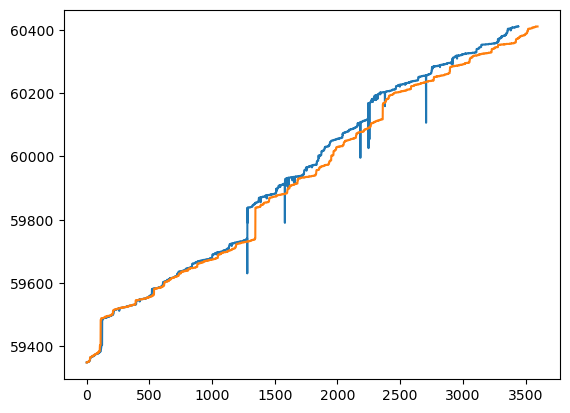

In [13]:
plt.plot(elg_cat_fibers[2]['MEAN_MJD'])
plt.plot(elg_cat_fibers[100]['MAX_MJD'])

In [17]:
def ordinal_pattern(values):
    """
    Compute the ordinal pattern of a sequence of values.
    """
    return sorted(range(len(values)), key=lambda k: values[k])

def permutation_entropy(time_series, order= 4, delay= 1):
    """
    Compute the permutation entropy of a 1D time series.

    Parameters:
    - time_series: The input time series (list of float values)
    - order: The order of permutation entropy (default: 4)
    - delay: The delay between values for computing ordinal patterns (default: 1)

    Returns:
    - Permutation entropy value
    """
    n = len(time_series)
    if n < order:
        raise ValueError(f"Time series length ({n}) must be at least as long as the order ({order})")
    
    permutations = {}
    
    for i in range(n - delay * (order - 1)):
        # Extract a subsequence
        pattern = [time_series[i + j * delay] for j in range(order)]
        # Compute its ordinal pattern
        ord_pattern = ordinal_pattern(pattern)
        # Convert to tuple for hashing
        ord_pattern = tuple(ord_pattern)
        
        if ord_pattern in permutations:
            permutations[ord_pattern] += 1
        else:
            permutations[ord_pattern] = 1
    
    # Compute probabilities and entropy
    total = sum(permutations.values())
    entropy = 0
    for count in permutations.values():
        p = count / total
        entropy -= p * np.log2(p)
    
    return entropy

In [28]:
def compute_entropy(cat_fibers):
    entropies = []
    fibers = []
    lenseries = []
    for i in cat_fibers.keys():
        if len(cat_fibers[i]['Z'])>200:
            f = cat_fibers[i]['Z']
            lenseries.append(len(f))
            fibers.append(i)
            entropy = permutation_entropy(f, order=4, delay=4)
        
            mean_entropy = 0.0
            n_iter = 5
            values = np.zeros(n_iter)
            for j in range(n_iter):
                shuffled_array = np.random.permutation(f)
                values[j] = permutation_entropy(shuffled_array, order=4, delay=4)
            
            entropies.append((entropy - values.mean())/values.std())
        
    entropies = np.array(entropies)
    fibers = np.array(fibers)
    lenseries = np.array(lenseries)
    return {'entropy': entropies, 'fibers':fibers, 'lenseries':lenseries}

In [29]:

#outliers_fibers = [53, 55, 56, 59, 64, 69, 185, 299, 333, 436, 551, 552, 553, 556, 562, 650, 675, 700, 725, 793, 817, 918, 919, 920, 997, 998, 1008, 1089, 1098, 1113, 1124, 1149, 1157, 1174, 1261, 1269, 1295, 1296, 1659, 1711, 1725, 1733, 1735, 1740, 1743, 1750, 1754, 1774, 1824, 1825, 1849, 1850, 1874, 1875, 1899, 1900, 1950, 1971, 1972, 2022, 2098, 2099, 2124, 2131, 2138, 2148, 2170, 2199, 2249, 2263, 2315, 2487, 2623, 2627, 2775, 2782, 2824, 2841, 2875, 2899, 2967, 3234, 3235, 3237, 3238, 3240, 3241, 3245, 3246, 3250, 3251, 3253, 3275, 3358, 3359, 3399, 3504, 3506, 3510, 3514, 3536, 3618, 3700, 3825, 3875, 3892, 3969, 3980, 3983, 3993, 3994, 4275, 4300, 4324, 4325, 4374, 4425, 4524, 4549, 4574, 4649, 4699, 4720, 4775,lenseries7, 4799, 4874, 4875, 4891, 4899, 4915]
#ii = np.isin(fibers, outliers_fibers)

In [30]:
entropy_bgs = compute_entropy(bgs_cat_fibers)

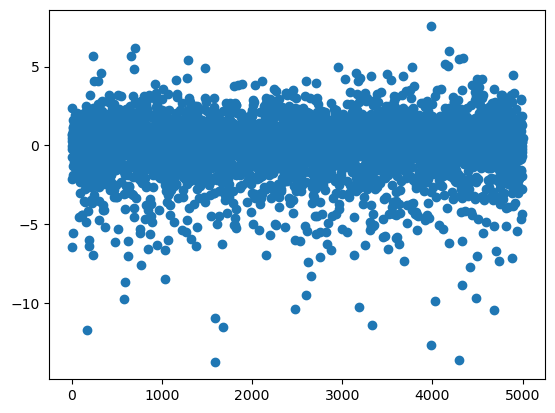

In [31]:
plt.scatter(entropy_bgs['fibers'], entropy_bgs['entropy'])
#plt.scatter(fibers[ii], values[ii])

In [62]:
entropy_bgs['fibers'][entropy_bgs['entropy']<-10]

array([ 170, 1589, 1591, 1682, 2481, 3187, 3333, 3984, 4298, 4682],
      dtype=int32)

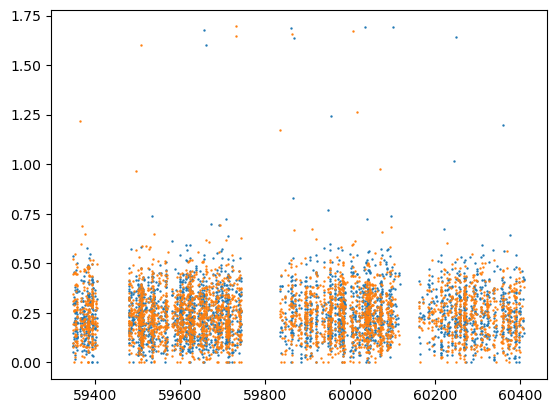

In [77]:
fiberid = 2481
plt.scatter(bgs_cat_fibers[fiberid]['MAX_MJD'], bgs_cat_fibers[fiberid]['Z'], s=0.5)

fiberid = 2001
plt.scatter(bgs_cat_fibers[fiberid]['MAX_MJD'], bgs_cat_fibers[fiberid]['Z'], s=0.5)